# Model finding

This notebook will work finding the best model to make predictions on our datas 

**Main goals are**: 
- Find or more suitable models
- Tune their parameters to improve their performances
- Evaluate their performance using different metrics

In [1]:
# Retreiving a significative amount of data
from local_lib.dataset import retreiveDatasetFromCsv

dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

**Image retreiving was created due to memory problem, since it is solved by reducing csv shape it is not necessary anymore**

**We use a custom flatten mask to make our data compatible with machine learning models**

In [2]:
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('image_mask', FlattenTransformer()),
])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

### First we restrict predicted data to 2 classes

In [5]:
import copy

# Make a copy of the list
y_simpler = copy.deepcopy(y)
y_simpler[y_simpler == 2] = 1
np.unique(y_simpler)

array([0, 1])

In [20]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=0)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train_pca_simpler, X_test_pca_simpler, y_train_simpler, y_test_simpler = train_test_split(X_pca, y_simpler, test_size=0.20, random_state=0)

In [5]:
#SIMPLER
from sklearn.model_selection import train_test_split
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X, y_simpler, test_size=0.2, random_state=0)

In [3]:
#FULL CLASS
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**We can consider a <72.79% accuracy as irrelevent**

**Uneven data distribution, we will generate more sample later but we stick with it for now**

Randomized search acheived 0.8899317406143344% Accuracy
Randomized search acheived 0.9952662721893492 Recall
Randomized search acheived 0.870600414078675 Precision


Text(0.5, 0.98, 'Confusion Matrix')

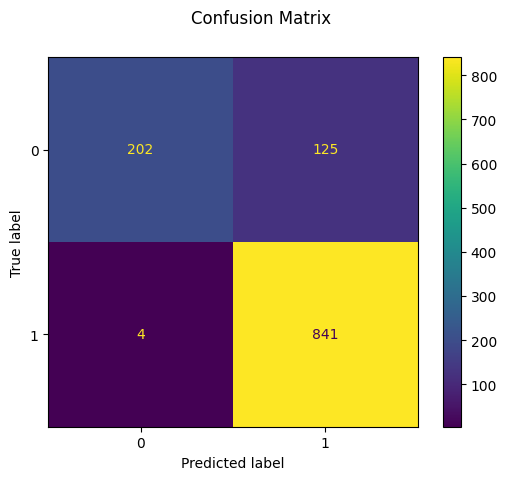

In [17]:
#2C no pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('norm', Normalizer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

pipeline.fit(X_train_simple, y_train_simple)
y_pred = pipeline.predict(X_test_simple)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test_simple, y_pred)
precision = precision_score(y_test_simple, y_pred)
recall = recall_score(y_test_simple, y_pred)


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.9257679180887372% Accuracy
Randomized search acheived 0.9680473372781065 Recall
Randomized search acheived 0.9316628701594533 Precision


Text(0.5, 0.98, 'Confusion Matrix')

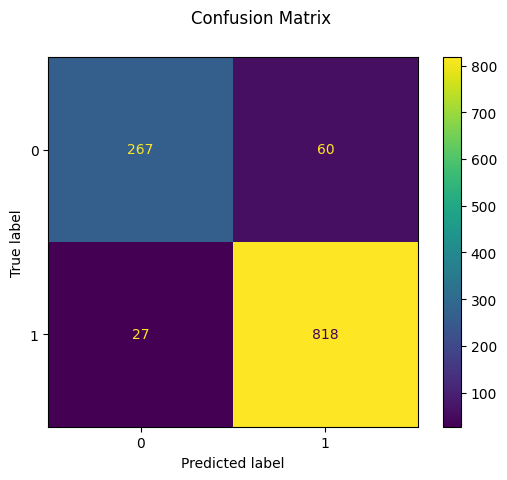

In [11]:
#2c pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('norm', Normalizer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

pipeline.fit(X_train_pca_simpler, y_train_simpler)
y_pred = pipeline.predict(X_test_pca_simpler)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test_simpler, y_pred)
precision = precision_score(y_test_simpler, y_pred)
recall = recall_score(y_test_simpler, y_pred)


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test_simpler, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.7175767918088737% Accuracy
Randomized search acheived 0.7175767918088737 Recall
Randomized search acheived 0.7397275070581504 Precision


Text(0.5, 0.98, 'Confusion Matrix')

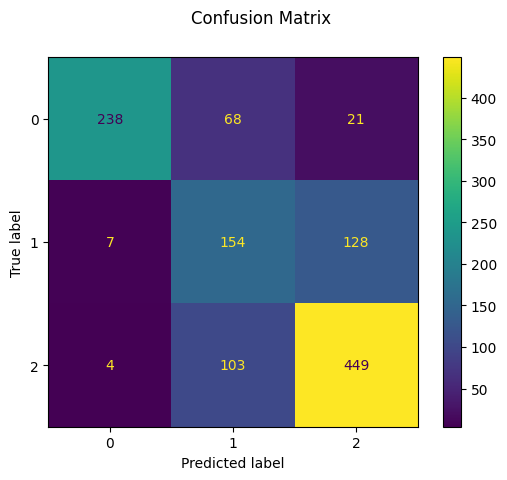

In [9]:
#3c no pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('norm', Normalizer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.7627986348122867% Accuracy
Randomized search acheived 0.7627986348122867 Recall
Randomized search acheived 0.759203824879287 Precision


Text(0.5, 0.98, 'Confusion Matrix')

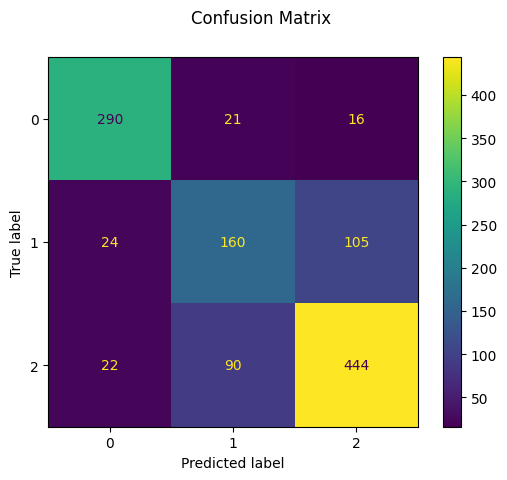

In [22]:
#3c pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('norm', Normalizer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

pipeline.fit(X_train_pca, y_train)
y_pred = pipeline.predict(X_test_pca)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.9334470989761092% Accuracy
Randomized search acheived 0.9727810650887574 Recall
Randomized search acheived 0.9372862029646523 Precision


Text(0.5, 0.98, 'Confusion Matrix')

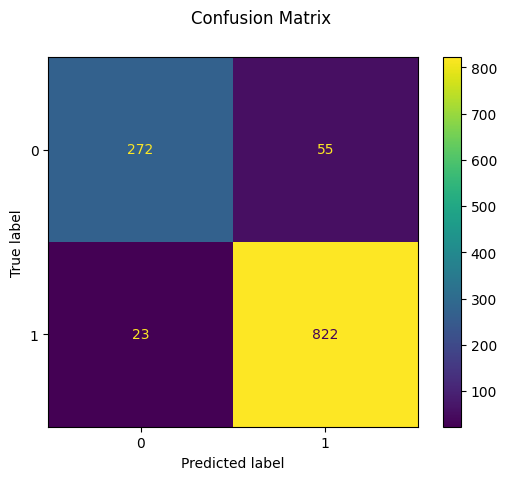

In [11]:
#2c no pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('norm', Normalizer()),
    ('knn', SVC(kernel='rbf'))
])

pipeline.fit(X_train_simple, y_train_simple)
y_pred = pipeline.predict(X_test_simple)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test_simple, y_pred)
precision = precision_score(y_test_simple, y_pred)
recall = recall_score(y_test_simple, y_pred)


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.947098976109215% Accuracy
Randomized search acheived 0.9727810650887574 Recall
Randomized search acheived 0.9547038327526133 Precision


Text(0.5, 0.98, 'Confusion Matrix')

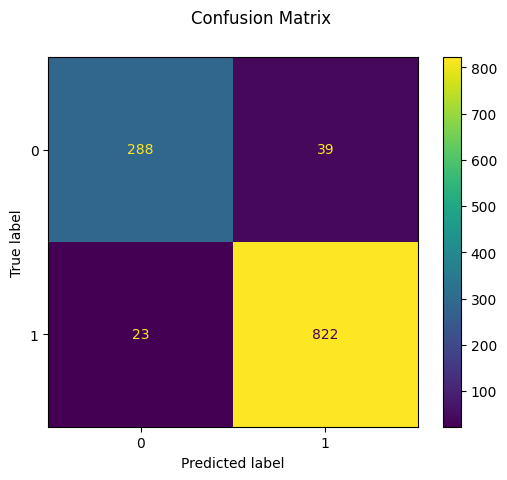

In [16]:
#2c pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('norm', Normalizer()),
    ('knn', SVC(kernel='rbf', C=1.8))
])

pipeline.fit(X_train_pca_simpler, y_train_simpler)
y_pred = pipeline.predict(X_test_pca_simpler)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test_simpler, y_pred)
precision = precision_score(y_test_simpler, y_pred)
recall = recall_score(y_test_simpler, y_pred)


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test_simpler, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.7670648464163823% Accuracy
Randomized search acheived 0.7670648464163823 Recall
Randomized search acheived 0.7604515830983998 Precision


Text(0.5, 0.98, 'Confusion Matrix')

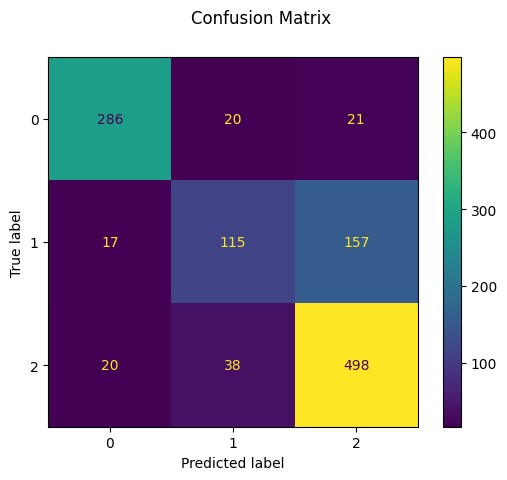

In [10]:
#3c no pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('norm', Normalizer()),
    ('knn', SVC(kernel='rbf'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.7935153583617748% Accuracy
Randomized search acheived 0.7935153583617748 Recall
Randomized search acheived 0.7873108486443217 Precision


Text(0.5, 0.98, 'Confusion Matrix')

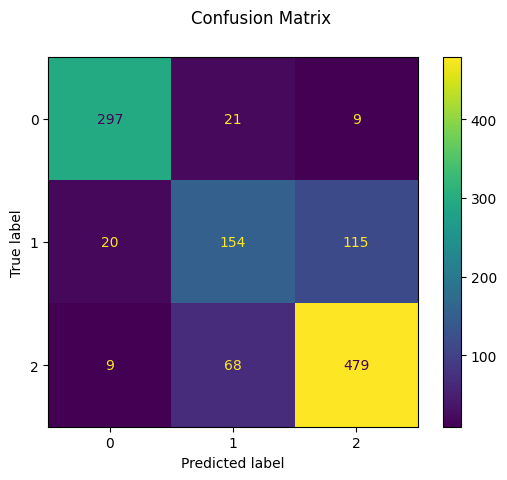

In [26]:
#3c pca
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

pipeline = Pipeline([
    ('norm', Normalizer()),
    ('knn', SVC(kernel='rbf', C=1.8))
])

pipeline.fit(X_train_pca, y_train)
y_pred = pipeline.predict(X_test_pca)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.9180887372013652% Accuracy
Randomized search acheived 0.9928994082840237 Recall
Randomized search acheived 0.9031216361679225 Precision


Text(0.5, 0.98, 'Confusion Matrix')

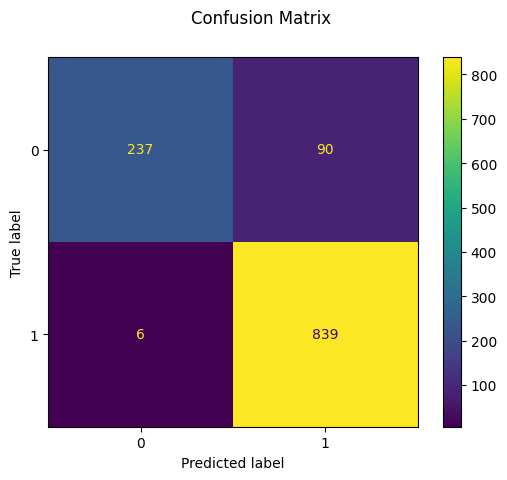

In [12]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

knn_combined = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_geo = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="geometry")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_seuil = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="baseline")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_sample_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_minmax = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_standard = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

eclf1 = VotingClassifier(estimators=[
    ('knn_combined', knn_combined),
    ('knn_geo', knn_geo),
    ('knn_seuil', knn_seuil),
    ('knn_sample', knn_sample),
    ('knn_sample_minmax', knn_sample_minmax),
    ('knn_sample_standard', knn_sample_standard),
    ('knn_combined_minmax', knn_combined_minmax),
    ('knn_combined_standard', knn_combined_standard)],
    voting='soft')

eclf1.fit(X_train_simple, y_train_simple)
y_pred = eclf1.predict(X_test_simple)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test_simple, y_pred)
precision = precision_score(y_test_simple, y_pred)
recall = recall_score(y_test_simple, y_pred)


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.9377133105802048% Accuracy
Randomized search acheived 0.978698224852071 Recall
Randomized search acheived 0.937641723356009 Precision


Text(0.5, 0.98, 'Confusion Matrix')

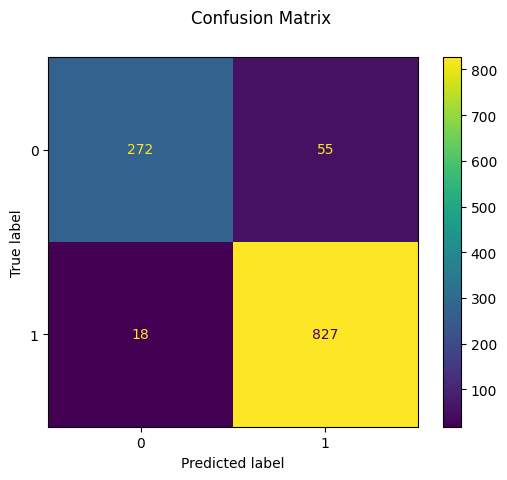

In [19]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

knn_combined = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_geo = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_seuil = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_sample_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

eclf1 = VotingClassifier(estimators=[
    ('knn_combined', knn_combined),
    ('knn_geo', knn_geo),
    ('knn_seuil', knn_seuil),
    ('knn_sample', knn_sample),
    ('knn_sample_minmax', knn_sample_minmax),
    ('knn_sample_standard', knn_sample_standard),
    ('knn_combined_minmax', knn_combined_minmax),
    ('knn_combined_standard', knn_combined_standard)],
    voting='soft')

eclf1.fit(X_train_pca_simpler, y_train_simpler)
y_pred = eclf1.predict(X_test_pca_simpler)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test_simpler, y_pred)
precision = precision_score(y_test_simpler, y_pred)
recall = recall_score(y_test_simpler, y_pred)


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test_simpler, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Randomized search acheived 0.7431740614334471% Accuracy
Randomized search acheived 0.7431740614334471 Recall
Randomized search acheived 0.7570496325478445 Precision


Text(0.5, 0.98, 'Confusion Matrix')

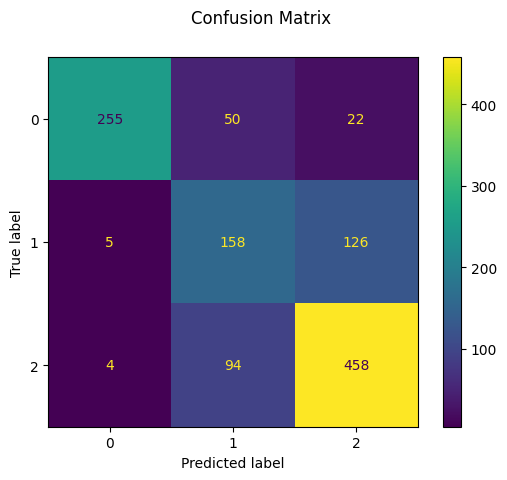

In [11]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

knn_combined = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_geo = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="geometry")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_seuil = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="baseline")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_sample_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_minmax = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_standard = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

eclf1 = VotingClassifier(estimators=[
    ('knn_combined', knn_combined),
    ('knn_geo', knn_geo),
    ('knn_seuil', knn_seuil),
    ('knn_sample', knn_sample),
    ('knn_sample_minmax', knn_sample_minmax),
    ('knn_sample_standard', knn_sample_standard),
    ('knn_combined_minmax', knn_combined_minmax),
    ('knn_combined_standard', knn_combined_standard)],
    voting='soft')

eclf1.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

knn_combined = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_geo = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_seuil = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_sample_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

eclf1 = VotingClassifier(estimators=[
    ('knn_combined', knn_combined),
    ('knn_geo', knn_geo),
    ('knn_seuil', knn_seuil),
    ('knn_sample', knn_sample),
    ('knn_sample_minmax', knn_sample_minmax),
    ('knn_sample_standard', knn_sample_standard),
    ('knn_combined_minmax', knn_combined_minmax),
    ('knn_combined_standard', knn_combined_standard)],
    voting='soft')

eclf1.fit(X_train_pca, y_train)
y_pred = eclf1.predict(X_test_pca)

# Calculate precision and recall and accuracy
ac = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


print("Randomized search acheived " + str(ac) + "% Accuracy")
print("Randomized search acheived " + str(recall) + " Recall")
print("Randomized search acheived " + str(precision) + " Precision")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

Apparently our intuition were good and the combined mask tends to improve recall

**Trying to create sample values to balance dataset**

In [12]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# Before applying SMOTE
print("Class distribution before SMOTE:")
print("Class 0:", sum(y_simpler == 0))
print("Class 1:", sum(y_simpler == 1))

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_simpler, y_resampled_simpler = smote.fit_resample(X, y_simpler)

# After applying SMOTE
print("\nClass distribution after SMOTE:")
print("Class 0:", sum(y_resampled_simpler == 0))
print("Class 1:", sum(y_resampled_simpler == 1))


Class distribution before SMOTE:
Class 0: 1583
Class 1: 4273

Class distribution after SMOTE:
Class 0: 4273
Class 1: 4273


In [13]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_resampled_simpler, y_resampled_simpler, test_size=0.33, random_state=0)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train_simple, y_train_simple)
accTrain = round(pipeline.score(X_train_simple, y_train_simple) * 100, 2)
accTest = round(pipeline.score(X_test_simple, y_test_simple) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 95.37% Accuracy - [TrainSet]
Combined mask accuracy is around 93.94% Accuracy - [TestSet]


Confusion matrix:
[[1398   27]
 [ 144 1252]]


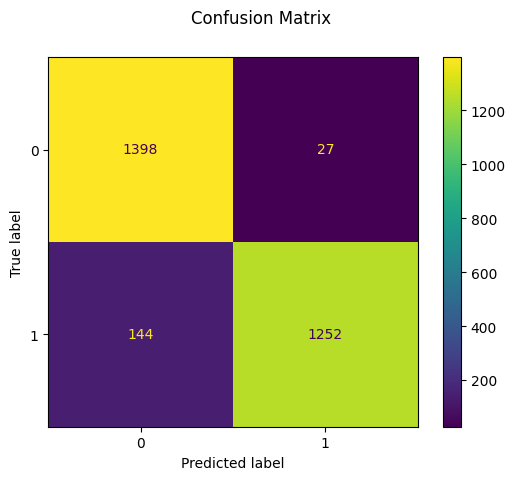

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_simpler = pipeline.predict(X_test_simple)
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

### **Remarkable accuracy but recall is worse and the model is making a lot of false positive**

So, as long as our objective is to trigger warnings on pneumonia we prefer a less accurate model with very few false positive. We won't use balancing data strategy

In [14]:
from sklearn.model_selection import train_test_split

#Get back with unbalanced data

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X, y_simpler, test_size=0.33, random_state=0)

**Important :** Bellow you can see that we evaluate final accuracy on unseen data because even if we used cross-validation we provided only 77% of the dataset to keep completly fresh eye on final result

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('knn', KNeighborsClassifier())
])

param_grid = {
              'knn__n_neighbors': [3, 5, 8, 10, 13]
              }

grid_search = GridSearchCV(
                    pipeline,
                    param_grid=param_grid,
                    cv=5,
                    n_jobs=8,
                    scoring='recall').fit(X_train_simple, y_train_simple)

ac = round(grid_search.score(X_test_simple, y_test_simple) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
grid_search.best_params_

Randomized search acheived 98.8% Accuracy


{'knn__n_neighbors': 13}

**n_neighbors: 13 and image_mask: combined seems to work well**

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from local_lib.testerTransformer import TesterTransformer
from sklearn.model_selection import GridSearchCV
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('tester_tr', TesterTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

param_grid = {
              'tester_tr__strategy' : ["StandardScaler","MinMaxScaler","Normalizer", "None"]
              }

grid_search = GridSearchCV(
                    pipeline,
                    param_grid=param_grid,
                    cv=5,
                    scoring='recall').fit(X_train_simple, y_train_simple)


ac = round(grid_search.score(X_test_simple, y_test_simple) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
grid_search.best_params_

Randomized search acheived 99.36% Accuracy


{'tester_tr__strategy': 'Normalizer'}

In [67]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score

param_grid = ["StandardScaler", "MinMaxScaler", "Normalizer", "None"]

results = {
        "StandardScaler":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "MinMaxScaler":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "Normalizer":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "None":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
}

for strategy in param_grid:
    print("Processing " +strategy+ "...")
    pipeline = Pipeline([
        ('image_mask', MaskSeuilTransformer(strategy='combined')),
        ('tester_tr', TesterTransformer(strategy=strategy)),
        ('knn', KNeighborsClassifier(n_neighbors=13))
    ])

    pipeline.fit(X_train_simple, y_train_simple)
    y_pred = pipeline.predict(X_test_simple)

    results[strategy]["accuracies"] = pipeline.score(X_test_simple, y_test_simple)
    print("Mean accuracy :" + str(results[strategy]["accuracies"]))

    results[strategy]["recalls"] = recall_score(y_test_simple, y_pred)
    print("Mean recall " + str(results[strategy]["recalls"]))

    results[strategy]["precisions"] = precision_score(y_test_simple, y_pred)
    print("Mean precision " + str(results[strategy]["recalls"]))



Processing StandardScaler...
Mean accuracy :0.8913605794102432
Mean recall 0.9943262411347518
Mean precision 0.9943262411347518
Processing MinMaxScaler...
Mean accuracy :0.892912571132954
Mean recall 0.9943262411347518
Mean precision 0.9943262411347518
Processing Normalizer...
Mean accuracy :0.8898085876875323
Mean recall 0.9936170212765958
Mean precision 0.9936170212765958
Processing None...
Mean accuracy :0.8898085876875323
Mean recall 0.9936170212765958
Mean precision 0.9936170212765958


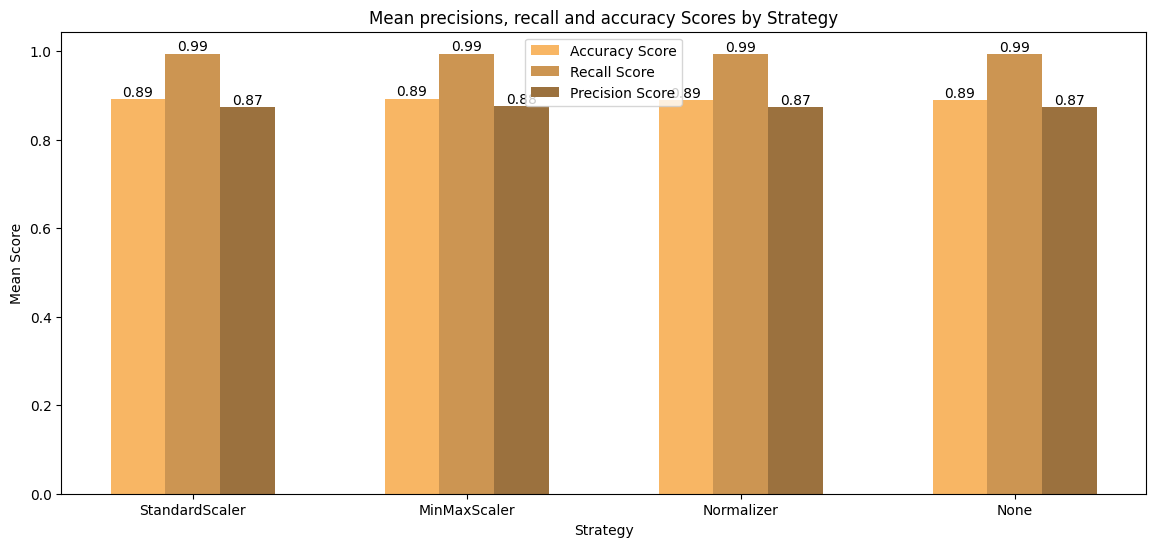

In [69]:
# Calculate mean test and train scores for each split
param_grid = ["StandardScaler", "MinMaxScaler", "Normalizer", "None"]

mean_accuracy = [results[strat]["accuracies"] for strat in param_grid]
mean_recall = [results[strat]["recalls"] for strat in param_grid]
mean_precision = [results[strat]["precisions"] for strat in param_grid]

# Strategy names
bar_width=0.2


# Plot bar chart for mean scores
plt.figure(figsize=(14, 6))
plt.bar(np.arange(len(param_grid)) - bar_width, mean_accuracy, width=bar_width, label='Accuracy Score', color='#F8B664')
plt.bar(np.arange(len(param_grid)) + 0, mean_recall, width=bar_width, label='Recall Score', color='#CC9552')
plt.bar(np.arange(len(param_grid)) + bar_width, mean_precision, width=bar_width, label='Precision Score', color='#9B713E')

i=0
for strat in param_grid:
    plt.text(i-bar_width, results[strat]["accuracies"], str(round(results[strat]["accuracies"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i, results[strat]["recalls"], str(round(results[strat]["recalls"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i+bar_width, results[strat]["precisions"], str(round(results[strat]["precisions"], 2)), ha='center', va='bottom')
    i+=1

plt.xticks(np.arange(len(param_grid)), param_grid)
plt.xlabel('Strategy')
plt.ylabel('Mean Score')
plt.title('Mean precisions, recall and accuracy Scores by Strategy')
plt.legend()
plt.show()

**Normalizer seems to improve recall a bit, but in general they all tends to improve except standardScaler**

Displaying learning curve, recall and precision

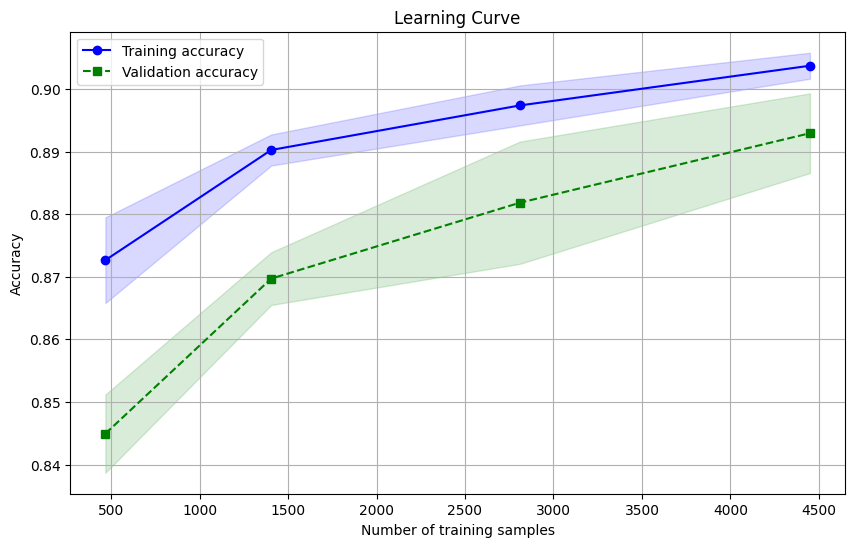

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('normalizer', Normalizer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y_simpler,
    train_sizes=[0.1, 0.3, 0.6, 0.95],
    n_jobs=8,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### **Clearly our model is not overfitting**

Thought, we can see that the accuracy is not at its prime values since we already experienced 95% accuracy.
Bellow see why this approach is more suitable to this specific medical problematic

In [24]:
from sklearn.model_selection import cross_val_score

# Calculate accuracy, precision and recall using cross validation
precision = cross_val_score(pipeline, X, y_simpler, cv=5, scoring='precision')
recall = cross_val_score(pipeline, X, y_simpler, cv=5, scoring='recall')
accuracy = cross_val_score(pipeline, X, y_simpler, cv=5, scoring='accuracy')

print("vvv Mean scores vvv:")
print("Precision:", precision.mean())
print("Recall:", recall.mean())
print("Accuracy:", accuracy.mean())


vvv Mean scores vvv:
Precision: 0.8766863586734926
Recall: 0.9927452511059067
Accuracy: 0.8927578598846411


Confusion matrix:
[[ 319  204]
 [   9 1401]]


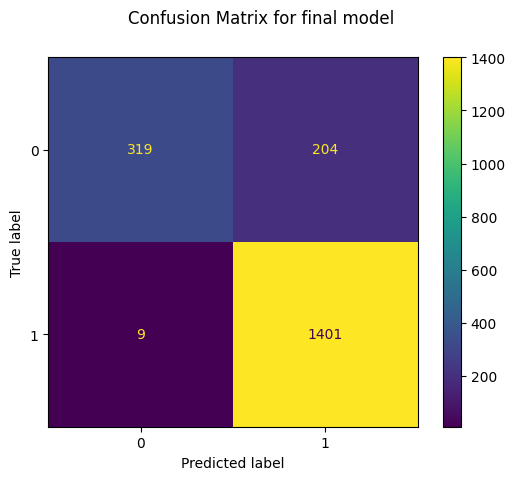

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
pipeline.fit(X_train_simple, y_train_simple)
y_pred_simpler = pipeline.predict(X_test_simple)
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix for final model")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

### Recap:
 - 89.2% accuracy
 - 87.6% precision
 - 99.2% recall
 - homogeneous confusion matrix
 - coherent learning curve

### Conclusion:
We could have a more accurate model (see the 95% with combined mask and 5 neighbors and resampled data), but if we did that we would have get 144 out of ~1900 test values instead of **9** with our most advanced model<br>
Wich represent approximatly **0.4% of false positive**